# [Exploration 09] 나의 첫 번째 캐글 경진대회, 무작정 따라해보기

## 프로젝트 설명 
- 캐글 베이스라인 구축하는 방법
- 하이퍼 파라미터 튜닝을 통해 캐글 스코어 올리기   


## 프로젝트 목표
- 하이퍼 파라미터 튜닝
- 데이터 분석

## 01. load and preprocess data

In [185]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [186]:
data_dir = os.getenv('HOME')+'/Projects/Project_Aiffel/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [187]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- date 문자열 전처리

In [188]:
train['date'] = train['date'].apply(lambda i: i[2:6]).astype(int)  # int로 변경
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,1410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,1502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,1502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,1406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,1501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- **각 feature와 price의 상관관계**를 알아보고, 연관성이 적은 feature를 삭제하도록 하겠습니다.

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement' 'waterfront'
 'yr_renovated' 'yr_built' 'sqft_lot' 'long' 'sqft_lot15' 'id' 'condition'
 'zipcode' 'date']


<AxesSubplot:>

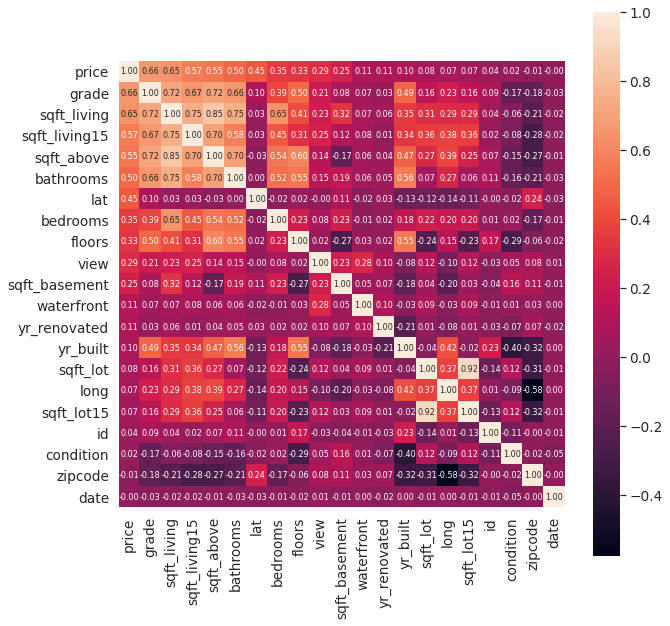

In [153]:
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=21,columns='price').index # 상위 10개 지정
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

In [157]:
train.zipcode[:10]

0    98178
1    98028
2    98074
3    98003
4    98198
5    98007
6    98115
7    98028
8    98074
9    98107
Name: zipcode, dtype: int64

- target data인 price 처리

In [189]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


- id 컬럼 삭제

In [190]:
del train['id']
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [139]:
train.describe()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,15035.000000,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,1438.545993,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,47.560721,-122.213677,1992.754772,12823.884935
std,44.252050,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,0.138164,0.141294,691.456442,27736.259787
min,1405.000000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000
25%,1407.000000,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,1410.000000,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,1502.000000,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,47.678300,-122.126000,2360.000000,10076.000000
max,1505.000000,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


In [140]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


- test data도 똑같이 전처리 해줍니다.
    - 단 price는 없음 

In [191]:
test['date'] = test['date'].apply(lambda i: i[2:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


- target data 전처리

In [142]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

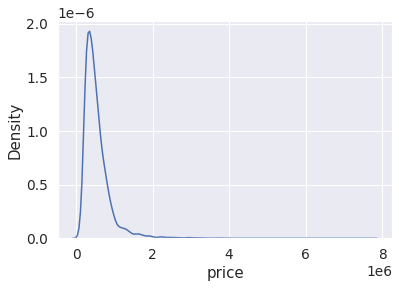

In [143]:
sns.kdeplot(y)
plt.show()

- 분포와 price값 스케일이 크다.
- 왼쪽으로 치우쳐져있는 price를 로그 변환처리해준다.

In [192]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

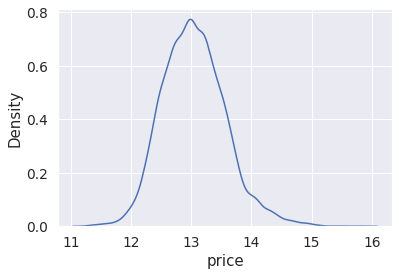

In [193]:
sns.kdeplot(y)
plt.show()

- 데이터의 스케일이 작아졌고, 분포도 정규분포와 비슷한 형태로 바뀌었다. 

In [194]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## 02. build and train model
- 하이퍼 파라미터 조정을 위한 함수 생성

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [15]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))  # np.expml : 원래 스케일로 되돌리기

In [16]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [158]:
random_state=1028

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [18]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [19]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 124131.19692815996,
 'XGBRegressor': 106615.63530702426,
 'LGBMRegressor': 107257.79913572696,
 'RandomForestRegressor': 134623.62574778864}

- 위의 과정을 함수로 생성

In [20]:
def get_scores(models, train, y):
    # 답안 작성
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train, y)

,RMSE
RandomForestRegressor,134623.625748
GradientBoostingRegressor,124131.196928
LGBMRegressor,107257.799136
XGBRegressor,106615.635307


## 03. tune hyperparameter
- 그리드 탐색

In [216]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 11], 
    'gamma': [0.5, 0.7, 0.3],
    'learning_rate': [0.029, 0.03],
    'boosting':["gbdt"],
    'num_iteration': [2500, 3000],
    "num_leaves" :[18, 19, 20],
    "objective" : ["regression"],
    "bagging_freq":[1],
    "bagging_fraction":[0.7, 0.8, 0.9]
}

In [217]:
model = LGBMRegressor(random_state=random_state)
# model = XGBRegressor(random_state=random_state)

In [218]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   28.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  9.5min
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed: 13.0min finished


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_iterations is set=2500, num_iteration=2500 will be ignored. Current value: num_iterations=2500
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=1028), n_jobs=5,
             param_grid={'bagging_fraction': [0.7, 0.8, 0.9],
                         'bagging_freq': [1], 'boosting': ['gbdt'],
                         'gamma': [0.5, 0.7, 0.3],
                         'learning_rate': [0.029, 0.03], 'max_depth': [10, 11],
                         'n_estimators': [100], 'num_iteration': [2500, 3000],
                         'num_leaves': [18, 19, 20],
                         'objective': ['regression']},
             scoring='neg_mean_squared_error', verbose=1)

In [24]:
import sklearn
sklearn. __version__ 

'0.23.1'

**keyerror base_score**   
    : sklearn version 0.23.0 -> 0.23.1로 업그레이드 후 해결   
- 결과 확인

In [226]:
grid_model.cv_results_

{'mean_fit_time': array([2.63224792, 2.64837022, 2.84697227, 3.22802453, 3.28184285,
        3.48750706, 2.67754664, 2.83303413, 2.99280853, 3.13400531,
        3.3576272 , 3.50441427, 2.82613697, 2.94486594, 2.88020701,
        3.33723264, 3.38000889, 3.54034038, 2.81627011, 2.61417789,
        2.89602284, 3.24577208, 3.29078574, 3.48756051, 2.72549186,
        2.84352541, 3.04157114, 3.54632387, 3.52691922, 3.61330976,
        3.00945125, 2.84903092, 3.04228649, 3.45581675, 3.50967851,
        3.65413461, 2.93880391, 3.09781413, 3.26069131, 3.49539981,
        3.55843029, 3.64182396, 2.95538907, 2.98048983, 3.21396246,
        3.56831579, 3.53305488, 3.8090239 , 2.6876441 , 2.96541104,
        3.13332219, 3.49576683, 3.62233443, 3.77484183, 2.92193151,
        2.96513252, 3.06479239, 3.26961904, 3.55287032, 3.77526422,
        2.93279853, 3.00580587, 3.10561748, 3.41493735, 3.58840814,
        3.7007761 , 2.91496043, 3.06241508, 3.04465837, 3.48801446,
        3.63242626, 3.62503672,

In [227]:
params = grid_model.cv_results_['params']
params

[{'bagging_fraction': 0.7,
  'bagging_freq': 1,
  'boosting': 'gbdt',
  'gamma': 0.5,
  'learning_rate': 0.029,
  'max_depth': 10,
  'n_estimators': 100,
  'num_iteration': 2500,
  'num_leaves': 18,
  'objective': 'regression'},
 {'bagging_fraction': 0.7,
  'bagging_freq': 1,
  'boosting': 'gbdt',
  'gamma': 0.5,
  'learning_rate': 0.029,
  'max_depth': 10,
  'n_estimators': 100,
  'num_iteration': 2500,
  'num_leaves': 19,
  'objective': 'regression'},
 {'bagging_fraction': 0.7,
  'bagging_freq': 1,
  'boosting': 'gbdt',
  'gamma': 0.5,
  'learning_rate': 0.029,
  'max_depth': 10,
  'n_estimators': 100,
  'num_iteration': 2500,
  'num_leaves': 20,
  'objective': 'regression'},
 {'bagging_fraction': 0.7,
  'bagging_freq': 1,
  'boosting': 'gbdt',
  'gamma': 0.5,
  'learning_rate': 0.029,
  'max_depth': 10,
  'n_estimators': 100,
  'num_iteration': 3000,
  'num_leaves': 18,
  'objective': 'regression'},
 {'bagging_fraction': 0.7,
  'bagging_freq': 1,
  'boosting': 'gbdt',
  'gamma': 0.5

In [228]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.02556187, -0.02553471, -0.02562671, -0.02569318, -0.02563172,
       -0.02573317, -0.02555029, -0.02555362, -0.02559161, -0.02565518,
       -0.02569174, -0.0257253 , -0.02548184, -0.02569079, -0.02562751,
       -0.02561452, -0.02582274, -0.02574161, -0.02542846, -0.02572903,
       -0.02563398, -0.02555656, -0.02585544, -0.02576457, -0.02556187,
       -0.02553471, -0.02562671, -0.02569318, -0.02563172, -0.02573317,
       -0.02555029, -0.02555362, -0.02559161, -0.02565518, -0.02569174,
       -0.0257253 , -0.02548184, -0.02569079, -0.02562751, -0.02561452,
       -0.02582274, -0.02574161, -0.02542846, -0.02572903, -0.02563398,
       -0.02555656, -0.02585544, -0.02576457, -0.02556187, -0.02553471,
       -0.02562671, -0.02569318, -0.02563172, -0.02573317, -0.02555029,
       -0.02555362, -0.02559161, -0.02565518, -0.02569174, -0.0257253 ,
       -0.02548184, -0.02569079, -0.02562751, -0.02561452, -0.02582274,
       -0.02574161, -0.02542846, -0.02572903, -0.02563398, -0.02

In [229]:
results = pd.DataFrame(params)
results['score'] = score

results

,bagging_fraction,bagging_freq,boosting,gamma,learning_rate,max_depth,n_estimators,num_iteration,num_leaves,objective,score
0,0.7,1,gbdt,0.5,0.029,10,100,2500,18,regression,-0.025562
1,0.7,1,gbdt,0.5,0.029,10,100,2500,19,regression,-0.025535
2,0.7,1,gbdt,0.5,0.029,10,100,2500,20,regression,-0.025627
3,0.7,1,gbdt,0.5,0.029,10,100,3000,18,regression,-0.025693
4,0.7,1,gbdt,0.5,0.029,10,100,3000,19,regression,-0.025632
...,...,...,...,...,...,...,...,...,...,...,...
211,0.9,1,gbdt,0.3,0.030,11,100,2500,19,regression,-0.025479
212,0.9,1,gbdt,0.3,0.030,11,100,2500,20,regression,-0.025492
213,0.9,1,gbdt,0.3,0.030,11,100,3000,18,regression,-0.025554
214,0.9,1,gbdt,0.3,0.030,11,100,3000,19,regression,-0.025585


- **최적화된 하이퍼 파라미터**

In [230]:
grid_model.best_params_

{'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'boosting': 'gbdt',
 'gamma': 0.5,
 'learning_rate': 0.029,
 'max_depth': 11,
 'n_estimators': 100,
 'num_iteration': 2500,
 'num_leaves': 20,
 'objective': 'regression'}

In [231]:
results['RMSLE'] = np.sqrt(-1 * results['score'])
results

,bagging_fraction,bagging_freq,boosting,gamma,learning_rate,max_depth,n_estimators,num_iteration,num_leaves,objective,score,RMSLE
0,0.7,1,gbdt,0.5,0.029,10,100,2500,18,regression,-0.025562,0.159881
1,0.7,1,gbdt,0.5,0.029,10,100,2500,19,regression,-0.025535,0.159796
2,0.7,1,gbdt,0.5,0.029,10,100,2500,20,regression,-0.025627,0.160083
3,0.7,1,gbdt,0.5,0.029,10,100,3000,18,regression,-0.025693,0.160291
4,0.7,1,gbdt,0.5,0.029,10,100,3000,19,regression,-0.025632,0.160099
...,...,...,...,...,...,...,...,...,...,...,...,...
211,0.9,1,gbdt,0.3,0.030,11,100,2500,19,regression,-0.025479,0.159621
212,0.9,1,gbdt,0.3,0.030,11,100,2500,20,regression,-0.025492,0.159661
213,0.9,1,gbdt,0.3,0.030,11,100,3000,18,regression,-0.025554,0.159857
214,0.9,1,gbdt,0.3,0.030,11,100,3000,19,regression,-0.025585,0.159954


- RMSLE를 기준으로 정렬

In [232]:
results = results.sort_values('RMSLE')
results[:10]

,bagging_fraction,bagging_freq,boosting,gamma,learning_rate,max_depth,n_estimators,num_iteration,num_leaves,objective,score,RMSLE
176,0.9,1,gbdt,0.7,0.029,11,100,2500,20,regression,-0.025427,0.159458
152,0.9,1,gbdt,0.5,0.029,11,100,2500,20,regression,-0.025427,0.159458
200,0.9,1,gbdt,0.3,0.029,11,100,2500,20,regression,-0.025427,0.159458
66,0.7,1,gbdt,0.3,0.030,11,100,2500,18,regression,-0.025428,0.159463
42,0.7,1,gbdt,0.7,0.030,11,100,2500,18,regression,-0.025428,0.159463
18,0.7,1,gbdt,0.5,0.030,11,100,2500,18,regression,-0.025428,0.159463
158,0.9,1,gbdt,0.5,0.030,10,100,2500,20,regression,-0.025450,0.159531
182,0.9,1,gbdt,0.7,0.030,10,100,2500,20,regression,-0.025450,0.159531
206,0.9,1,gbdt,0.3,0.030,10,100,2500,20,regression,-0.025450,0.159531
193,0.9,1,gbdt,0.3,0.029,10,100,2500,19,regression,-0.025453,0.159540


- 그리드 탐색을 통해, 최적의 하이퍼 파라미터를 알 수 있었다.(lgb, xgboost)
    - gamma = 0.5
    - learning rate = 0.05
    - max depth = 10
    - n_estimators = 100
    
## 04. 함수로 튜닝하면서 학습하기

In [58]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [233]:
model = LGBMRegressor(random_state=random_state, n_estimators=100,
    max_depth=11, 
    gamma=0.7,
    learning_rate=0.029,
    boosting="gbdt",
    num_iteration=2500,
    objective="regression",
    num_leaves=20,
     bagging_freq=1,
    bagging_fraction=0.9)
# model = XGBRegressor(max_depth=10, n_estimators=100, random_state=random_state)

# model.fit(train, y)
# prediction = model.predict(test)
# prediction

- 로그변환했던 것을 되돌려서 원래 스케일로 만들기

In [91]:
prediction = np.expm1(prediction)
prediction

array([ 522818.89981601,  456988.14154955, 1448213.03274214, ...,
        475968.16265556,  332686.00444277,  444926.26887956])

In [92]:
data_dir = os.getenv('HOME')+'/Projects/Project_Aiffel/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


- sample 프레임에 학습으로 예측한 값을 붙여주기

In [70]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.216855e+05
1,15036,4.572925e+05
2,15037,1.391553e+06
3,15038,3.045639e+05
4,15039,3.291502e+05


In [37]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.160072')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/aiffel-dj26/Projects/Project_Aiffel/data/submission_lgbm_RMSLE_0.160072.csv


In [148]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/Projects/Project_Aiffel/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [235]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.159458')

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_iterations is set=2500, num_iteration=2500 will be ignored. Current value: num_iterations=2500
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
/home/aiffel-dj26/Projects/Project_Aiffel/data/submission_lgbm_RMSLE_0.159458.csv saved!


## 05. 캐글 제출, 스코어 확인
---
![exp9_score](https://user-images.githubusercontent.com/68461606/108395270-f6e7b180-7258-11eb-8323-d2ac511bb821.png)


# 정리     
---        
1. 데이터 준비와 전처리
    - target data 분리
    - 불필요한 데이터 삭제
    - 정수형 데이터로 변환
    - 데이터 분포, 연관성 확인
2. 하이퍼 파라미터 튜닝
    - 그리드 서치를 이용해서 가장 잘 학습된 하이퍼 파라미터를 확인
3. 제출 파일 생성


# 루브릭 평가
---
1. **캐글 데이터분석 전과정이 성공적으로 진행되었는가?**   
    - 데이터 분석을 하고자 노력했으며 하이퍼 여러 파라미터 튜닝을 시도함


2. **전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?**  
    - 전체 흐름은 간략하게 서술했으며, 시각화를 히트맵으로 시도함 
    
     
3. **회귀모델 예측정확도가 기준 이상 높게 나왔는가?**  
    - 110000에 가까운 110294.34489 점을 달성함 

    
# 회고
---
## 어려웠던 점 
- 데이터 EDA 
    - 여러 시도가 필요한데, 아직 분석에 대한 부족함이 많다. 여러가지 시도를 해보면서 시행착오를 겪어야한다고 생각한다.
    - EDA 관련 Fundamental 노드 복습! 
    
## 알게된 점 
- low, high model
    - 트리 탐색을 이용한 모델들의 경우, 튜닝할 수 있는 하이퍼 파라미터에 따라 low, medium, high 모델로 나눌 수 있다.
    
## 더 공부할 점
- feature encoding
    - 다른 프로젝트를 할 때 모든 feature에 대해 label 혹은 one hot 인코딩을 했는데, 아이펠 노드에서는 자주 보지 못한 것 같다. regression에서는 잘 사용되지 않는 건지 더 공부해봐야겠다.
- 모델에 대한 이해
    - 모델에 대한 공부 없이 파라미터에 대해서만 간략히 공부 후 적용하려니 단순 반복과 감에 의존해야했던 점이 어려웠다.
    - 캐글에서 좋은 점수를 얻을 수 있는 모델들에 대해서도 구조를 공부해야겠다.
    
## 시도한 것들
- 데이터 전처리
    - price와 다른 feature들의 연관성을 시각화한 후, 가장 연관성이 적은 'zipcode'를 삭제
    - date에서 주택 가격이 연도보다 월에 영향을 더 많이 받을 것이라고 추측해 월만 남겨놓음 
- 하이퍼 파라미터 튜닝
    - n_estimators, max_depth, gamma, learning_rate, boosting, num_iteration, objective, num_leaves, bagging_freq, bagging_fraction 
    - 여러 파라미터로 다양한 시도를 함
    - 스케일을 넓게 잡고 그 안에서 더 작은 스케일로 그리드 탐색을 함 
    
## 지표 달성하지 못한 이유
- 데이터 전처리를 많이 하고 싶었으나, zipcode의 경우 위치 별로 범주형 카테고리로 나눴으면 어땠을까 한다. 여러 생각은 나는데 이걸 시도하기에 아직 두려움이 있다. 데이터 전처리가 어렵게 느껴지기 때문에 오히려 하이퍼 파라미터 튜닝에 힘을 썼다. 처음보다 지표에 가까운 점수를 만들어낼 수 있었지만, 앙상블을 더 했으면 좋았을 것 같다. xgboost는 너무 시간이 오래걸리고, 스코어가 매우 낮기 때문에 light bgm으로 선택했다. 탐색 깊이(하이퍼 파라미터)에 따라 low, high 모델로 나뉜다는 것을 알았기 때문에 파라미터를 나누어서 앙상블하면 결과가 어떨지 궁금하다. 
- 가장 큰 이유는 데이터 전처리를 더 다양하게 하지 못했기 때문이라고 생각한다.

## 다짐
- 캐글 해커톤때도 느꼈지만, 데이터와 친해지자!
- 데이터를 파고드는 연습이 필요하다.
- 랜덤 탐색도 시도해보고 싶다.